Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


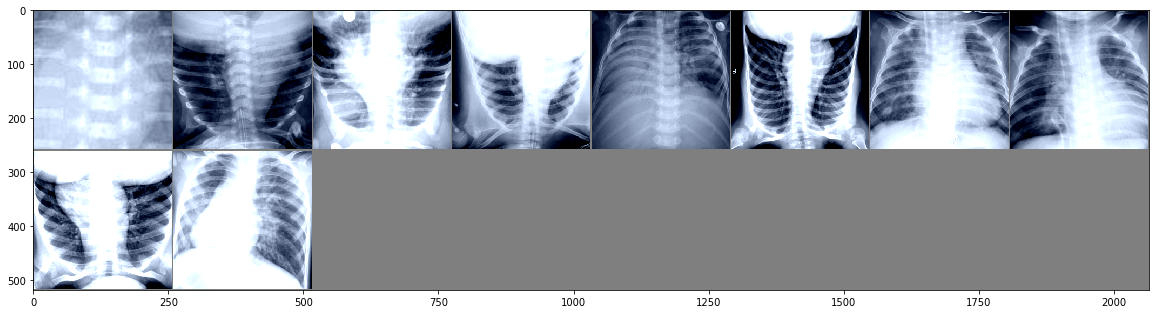

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import time

EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 0.0003
TRAIN_DATAPATH = 'chest_xray\\train'
VAL_DATAPATH = 'chest_xray\\val'
TEST_DATAPATH = 'chest_xray\\test'
TRANSFORM_IMG = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATAPATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
val_data = torchvision.datasets.ImageFolder(root=TEST_DATAPATH, transform=TRANSFORM_IMG)
val_data_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATAPATH, transform=TRANSFORM_IMG)
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_data_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))


In [8]:
class Base(nn.Module):
    def __init__(self):
        super(Base, self).__init__()
        self.conv1 = nn.Conv2d(3,20,kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        
        self.conv2 = nn.Conv2d(20,40,kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        
        self.conv3 = nn.Conv2d(40,80,kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        
        
        self.fc1 = nn.Linear(80*32*32,120)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120,84)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84,2)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self,x):
        x = self.pool1(self.relu((self.conv1(x))))
        x = self.pool2(self.relu((self.conv2(x))))
        x = self.pool3(self.relu((self.conv3(x))))
        x = x.view(-1,80*32*32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
#         x = self.softmax(x)
        return x

In [9]:
print("Number of Training Examples: ", len(train_data))
print("Number of Test Examples: ", len(test_data))
print("Number of Valid Examples: ", len(val_data))
print("Detected Classes are: ", train_data.class_to_idx)
train_iter = iter(train_data_loader)
images, labels_ = train_iter.next()
print("Image Shape on Batch size = {} ".format(images.size()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Base()
model.to(device)
criterion = nn.CrossEntropyLoss()
_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(_params, lr=LEARNING_RATE)



Number of Training Examples:  5216
Number of Test Examples:  624
Number of Valid Examples:  624
Detected Classes are:  {'NORMAL': 0, 'PNEUMONIA': 1}
Image Shape on Batch size = torch.Size([10, 3, 256, 256]) 
cuda:0


In [10]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(EPOCHS):
    start = time.time()
    print("EPOCH: ",epoch)
    correct = 0 
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i,data in enumerate(train_data_loader,0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        iter_loss+=loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_data)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    model.eval()

    for i, data in enumerate(val_data_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
#         print(outputs)
#         print(predicted)
#         print(labels)
        correct += (predicted == labels).sum()

        iterations+=1

    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(val_data)))
    stop = time.time()
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}, Time: {:.3f}s'
           .format(epoch+1, EPOCHS, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

    

EPOCH:  0
Epoch 1/10, Training Loss: 0.397, Training Accuracy: 77.000, Validation Loss: 0.026, Validation Acc: 77.000, Time: 59.550s
EPOCH:  1
Epoch 2/10, Training Loss: 0.336, Training Accuracy: 80.000, Validation Loss: 0.001, Validation Acc: 76.000, Time: 58.298s
EPOCH:  2
Epoch 3/10, Training Loss: 0.254, Training Accuracy: 80.000, Validation Loss: 0.007, Validation Acc: 75.000, Time: 58.109s
EPOCH:  3
Epoch 4/10, Training Loss: 0.231, Training Accuracy: 82.000, Validation Loss: 0.022, Validation Acc: 73.000, Time: 58.600s
EPOCH:  4
Epoch 5/10, Training Loss: 0.232, Training Accuracy: 81.000, Validation Loss: 0.038, Validation Acc: 77.000, Time: 57.835s
EPOCH:  5
Epoch 6/10, Training Loss: 0.224, Training Accuracy: 81.000, Validation Loss: 0.066, Validation Acc: 72.000, Time: 58.544s
EPOCH:  6
Epoch 7/10, Training Loss: 0.213, Training Accuracy: 82.000, Validation Loss: 0.001, Validation Acc: 76.000, Time: 57.462s
EPOCH:  7
Epoch 8/10, Training Loss: 0.200, Training Accuracy: 83.000

In [11]:
correct = 0
total = 0
classes =['0','1']
confusion_matrix = torch.zeros(2, 2)
correct_0 = 0
correct_1 = 0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_data_loader:
        images,labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
#         print('Predicted: ' + str(predicted))
#         print('Labels: ' + str(labels))
        total += labels.size(0)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        correct+=(predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
acc = 100*correct/total
print(correct)
print(total)
print('Testing accuracy: ' + str(acc))
print(confusion_matrix)

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

477
624
Testing accuracy: 76.4423076923077
tensor([[ 98., 136.],
        [ 11., 379.]])
Accuracy of     0 : 34 %
Accuracy of     1 : 95 %


In [7]:
print("PyTorch version: ", torch.__version__ )
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)

PyTorch version:  1.2.0
CUDA available:  True
CUDA version:  10.0


In [8]:
torch.cuda.empty_cache()